# Project: Finding lane lines on the road

The objective of the project is to develop an alogrithm with is able to detect lane lines in images and video streams.
The approach which I took is motivated by the results described in [Chang et al](http://ieeexplore.ieee.org/document/6332016/). The different steps are illustrated in Fig. 1. First all images are converted to grayscale. After applying a Gaussian filter I use the well-known Canny edge detection algorithm to detect all edges. 

![workflow](images/workflow.png)
__Fig. 1__ _Illustration of the various steps of the algorithm used to detect lane lines. Steps which exlusively remove noisy edges are highlighted in red._

Besides the actual lane line other objects are detected as well ("noisy edges"). I apply special properties of lane lines in order to filter most of the noisy edges. I assume that actual lane lines have an angle in the range $15^{\circ}-165^{\circ}$ with respect to the y-axis. Any line which does not fall in this range is filtered. Next I exploit the oberservation that a line lane consits of two parallel lines (after Canny edge detection) whose gradients exhibit special properties (see section 5 for a detailed discussion). The third filter is a simple region selection. Since lane lines always appear in the same general region of the image one can employ a region selection given by a quadrilateral. The fourth filter exploits that lane lines are painted with high contrast color to the road surface. This allows to apply Otsu's method which conducts automatic pixel clustering. 

Lastly, the remaining edges are fitted with a Hough transform. The detected lines are assumed to be lane lines and highlighted in red on the orginal image. 

Each of the steps is described in detail in the next sections starting with a look at the original images.


## 1. Original pictures

First let's have a look at the original pictures. Besides the six test images provided by Udacity I added two images myself. Those are taken from the "challenge" video which is part of the repository as well. After exploration of the initial six images one can highlight the following observations:
* all lane lines are straight 
* they always appear in the same general region of the image
* lane lines are painted in high contrast color to the road surface (either white or yellow) 
* light conditions are similar.

Things become more challenging with the two images of the "challenge" video:
* slight curvature of lane lines
* light conditions vary because of shadows or bright sunlight
* other cars are much closer
* a part of the car is visible in the bottom of the picture.

We need to develop a algorithm which is general enough as well as robust enough to detect lane lines reliabely under varying conditions. 

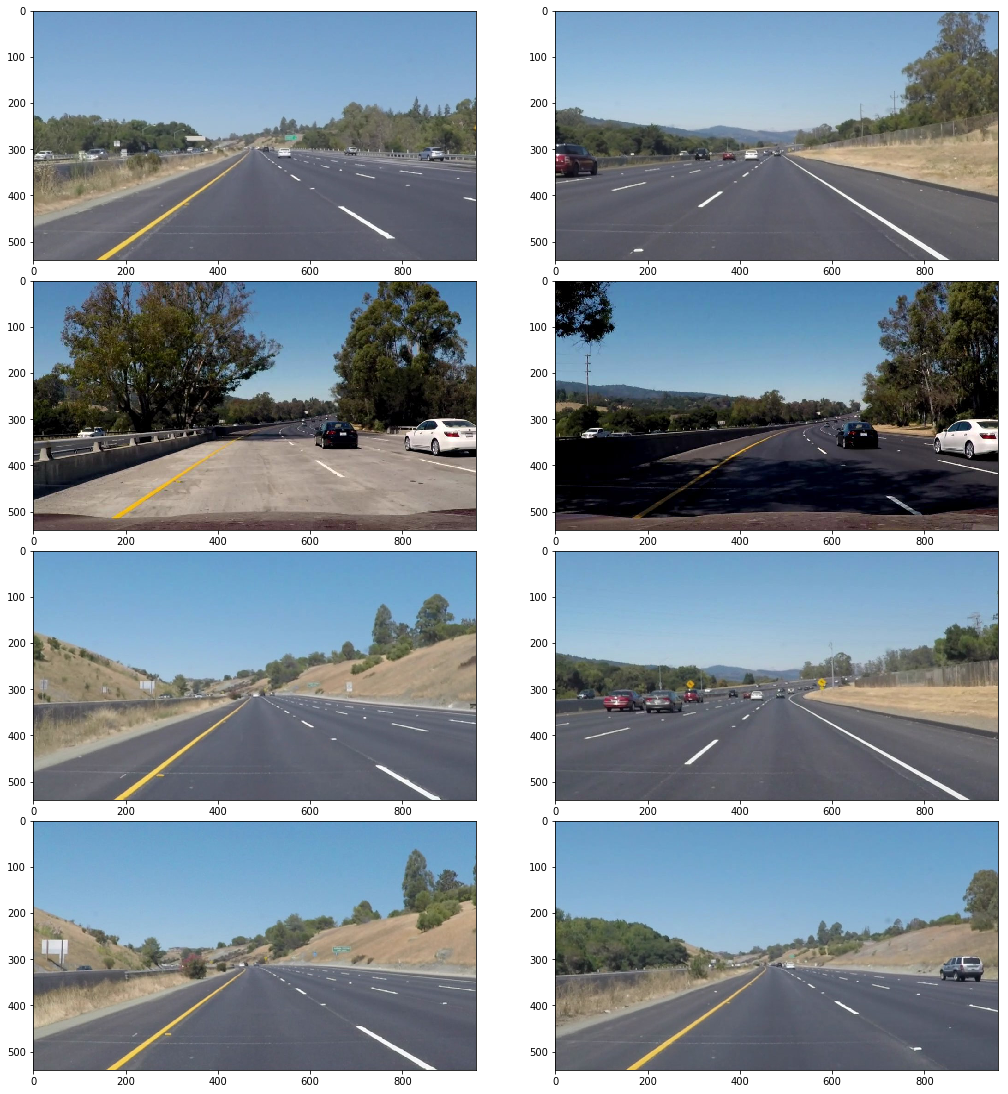

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

def display_images(images, figsize = (15, 10)):
    "Display images in two columns. Choose gray-scale colorbar if image is two-dimensional."
    ncols = 2
    nrows = np.ceil(len(images)/2)
    
    fig = plt.figure(figsize = figsize)
    for i, image in enumerate(images, start = 1):
        ax = fig.add_subplot(nrows, ncols, i)
        plt.imshow(image) if len(image.shape) == 3 else plt.imshow(image, cmap='gray')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    

images = [mpimg.imread(image) for image in glob.glob("test_images/*.jpg")]

display_images(images, figsize = (15, 15))

## 2. Grayscale transformation

The Cany edge-detection algorithm expects a grayscale image as input. Typically the following formula is applied to conduct grayscale conversion from RGB colorspace
$$Gray = 0.299\cdot R + 0.587\cdot G + 0.114\cdot B.$$
Lane line markings are painted in high contrast colors (white, yellow, red) to the dark road surface. It would be  	advantageous for the application of the Cany algorithms (allows to set higher thresholds and filter more noisy edges) if we choose a transformation which enhances the contrast between a dark pixel and a yellow/white/red pixel. This can be achieved through 
$$Gray = R + G - B.$$

As illustrated in the following toy problem the contrast (i.e. difference in intensities) betweeen white/yellow/red pixels and gray/black pixels is significantly enhanced using $R+G-B$ compared to $0.299\cdot R + 0.587\cdot G + 0.114\cdot B$.

Intensity values of image after grayscale transformation 0.299R+0.587G+0.114B:
white: 255   yellow: 226   red: 76   gray: 140   black: 0
Intensity values of image after grayscale transformation R+G-B:
white: 255   yellow: 255   red: 255   gray: 140   black: 0


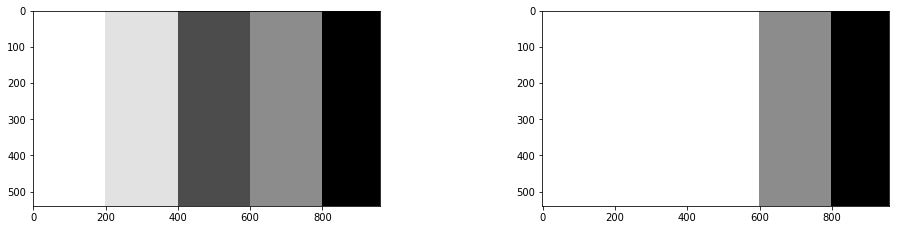

In [6]:
def grayscale(img):
    "Applies the Grayscale transform according to 0.299*R+0.587*G+0.114*B."
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def grayscale2(img):
    "Applies the Grayscale transform according to R+G-B."
    gray = img[:, :, 0].astype('int16') + img[:, :, 1].astype('int16') - img[:, :, 2].astype('int16') 
    gray[gray > 255] = 255
    gray[gray < 0] = 0
    return gray.astype('uint8')


# create picture with white, yellow, red, gray and black regions
imgo = np.zeros_like(np.copy(images[0]))
imgo[:, 0:200]   = [255, 255, 255]
imgo[:, 200:400] = [255, 255, 0]
imgo[:, 400:600] = [255, 0, 0]
imgo[:, 600:800] = [140, 140, 140]
imgo[:, 800:]    = [0, 0, 0]

# grayscale conversion
img_g1 = grayscale(imgo)
img_g2 = grayscale2(imgo)

# intensity values
print('Intensity values of image after grayscale transformation 0.299R+0.587G+0.114B:')
print("white: %d   yellow: %d   red: %d   gray: %d   black: %d" % 
      (img_g1[1, 150], img_g1[1, 250], img_g1[1, 450], img_g1[1, 650], img_g1[1, 850]))
print('Intensity values of image after grayscale transformation R+G-B:')
print("white: %d   yellow: %d   red: %d   gray: %d   black: %d" % 
      (img_g2[1, 150], img_g2[1, 250], img_g2[1, 450], img_g2[1, 650], img_g2[1, 850]))

display_images([img_g1, img_g2], figsize = (15, 3))

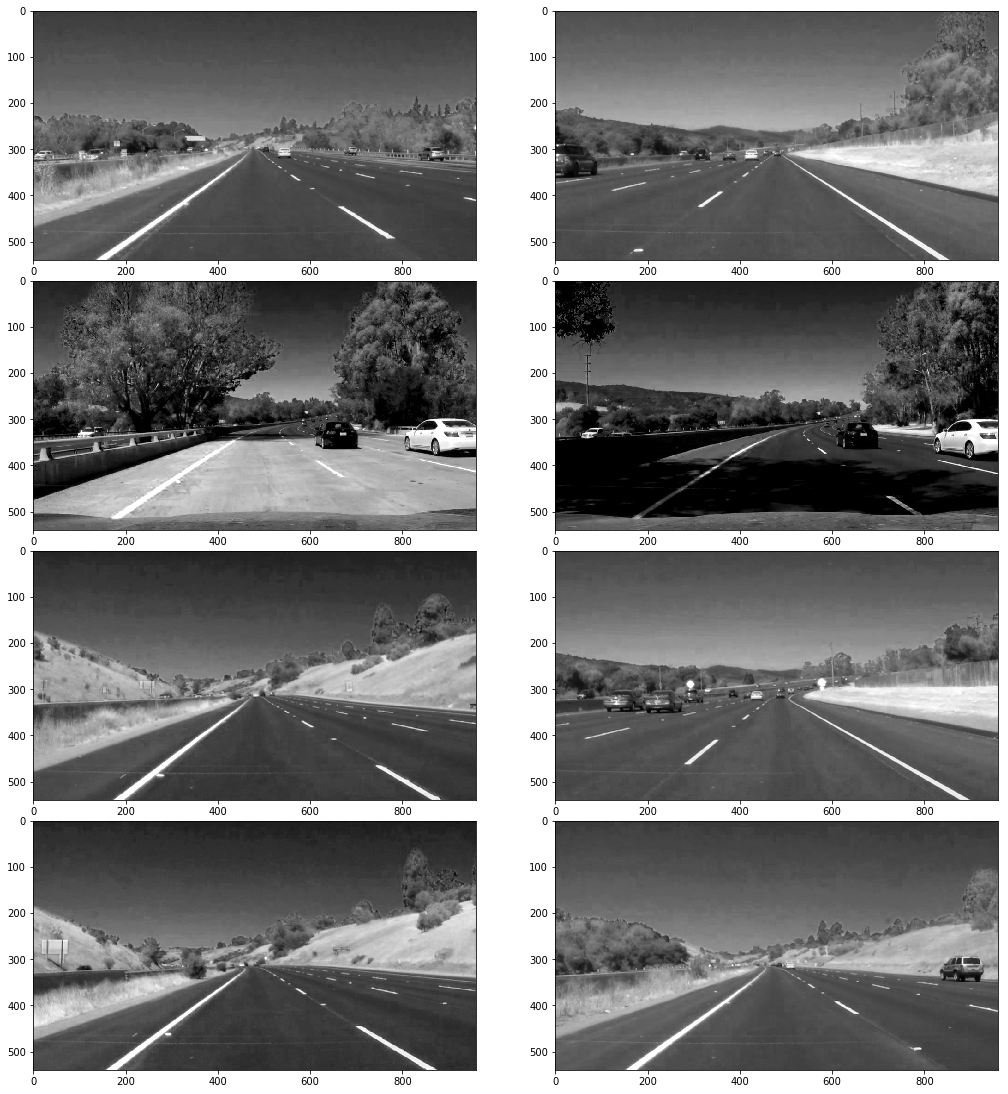

In [7]:
images_gray = np.copy(images)   

images_gray = [grayscale2(image) for image in images_gray]

    
display_images(images_gray, figsize = (15, 15))

## 3. Canny edge detection

Next we apply the Canny edge detection algorithm to the images. The algorithm consits of four steps
* apply a Gaussian filter in order to smooth the image 
* compute magnitude of the gradient vector for each pixel
* apply a double thresholding to the gradient
    * if gradient is larger than high threshold pixel is regarded as an edge
    * if gradient is smaller than the low threshold pixel is disgarded
    * if gardient is between high and low threshold pixel is marked as a potential edge
* check if "potential edge" pixels are connected to strong edges
    * if yes: regard them as edges
    * if no: disgard them
    
The algorithm tries to preserve pixels with high gradient values while filtering out pixels with low gradient values.

Since lane line marking are painted with a high contrast color to the road surface (we even enhanced this contrast with our choice of the grayscale conversion) we have a good chance to detect them even with high thresholds. It is important to optimize thresholds such that lane lines are still detected and noisy edges (i.e. edges which are not related to line lines) are suppressed as much as possible. The thresholds have to be adjusted empirically. Canny himself recommends a ratio between 1:2 and 1:3 for the low and high thresholds. Thresholds low_thresh = 50 and high_thresh = 150 work best for the problem at hand.

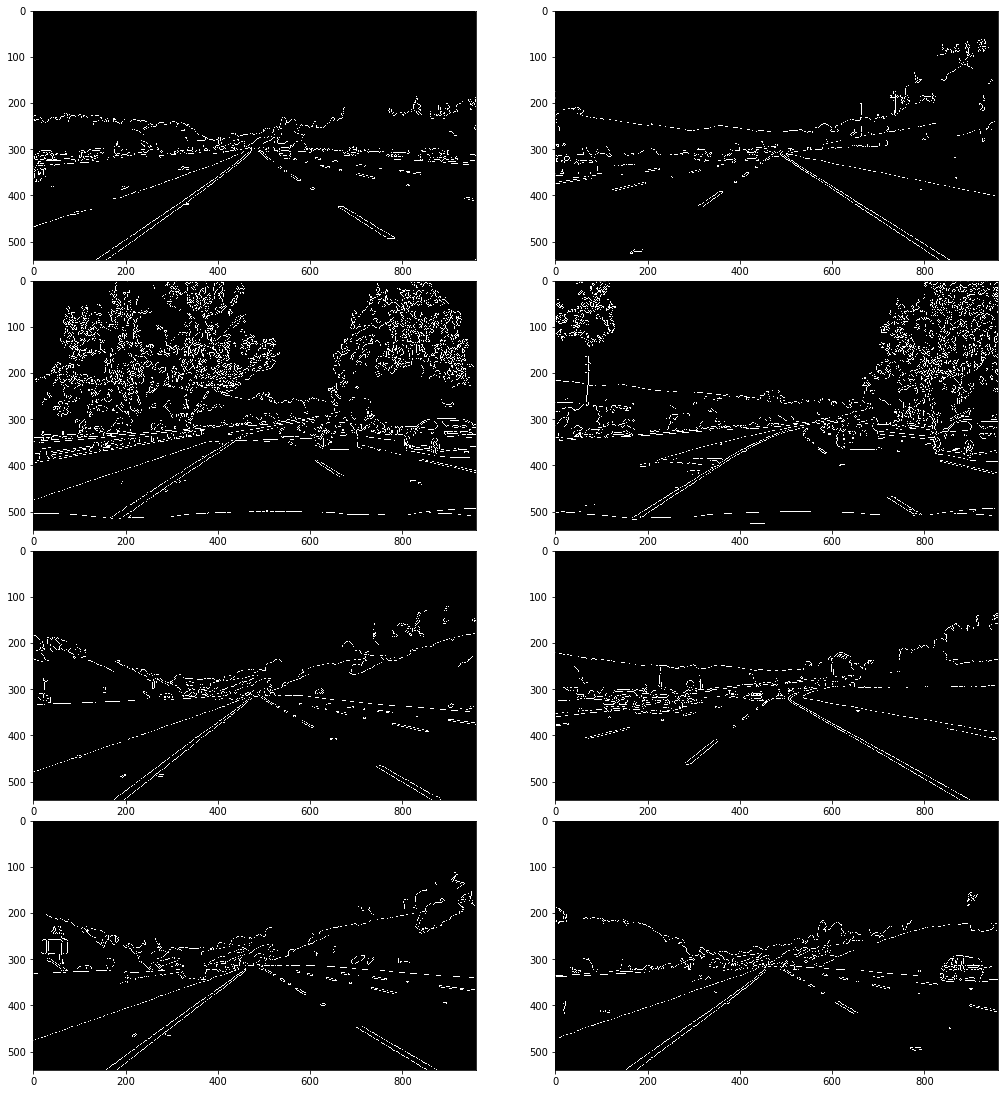

In [8]:
def canny(img, low_thresh, high_thresh):
    "Applies the Canny transform."
    return cv2.Canny(img, low_thresh, high_thresh)

blur_gray = [cv2.GaussianBlur(image, (5, 5), 0) for image in images_gray]
images_canny = [canny(image, 50, 150) for image in blur_gray]


display_images(images_canny, figsize = (15, 15))

## 4. Edge filtering based on edge orientation

Despite the optimization of high and low thresholds many noisy edges are still present in the images. These edges cannot be filtered out through a proper choice of thresholds alone. We try to filter out the remaining noisy edges by exploting specific knowledge about lane lines. 

Typical lane lines have an angle with respect to the y-axis in the interval [15$^{\circ}$:165$^{\circ}$]. Any line which doesn't fall in this range is most likely a noisy edge. Based on this oberservation we developed an algorithm to filter out edges with an unusal low (or high) angle with respect to the y-axis.  

First the image is divided in a grid of quadratical subimages with a size of 10x10 pixels. Next the Hough transform is applied to each subimage in order to find all lines. The angle of each line with respect to the y-axis and its magnitude is computed afterwards. If the angle is not in the interval [15$^{\circ}$:165$^{\circ}$] the line is assigned to class 'no lane marking' otherwise to class 'lane marking'. Finally the sum of magnituds of all lines in class 'no lane marking' are compared to the sum of magnituds of all lines in class 'lane marking'. If the sum of class 'no lane marking' is larger than the one of class 'lane marking' the subimage is zeroed assuming that no lane line marking is contained in this subimage. Otherwise the subimage is kept as is.

In [11]:
def subimage(image, size):
    """Return list of all sub-images. Each sub-image is represented by a tuple (sx1, sx2, sy1, sy2) such that
    image[sx1:sx2, sy1:sy2] gives the slice of the subimage.
    
    Args:
    image -- image to be divided in subimages
    size  -- size of subimage (size x size pixels). Size has to be a factor of xdim and ydim."""
    xdim, ydim = image.shape
    assert (xdim%size==0) and (ydim%size==0)
    nrow = ydim // size
    ncol = xdim // size
    return [(size*x, size*(x+1), size*y, size*(y+1))  for x in range(ncol) for y in range(nrow)]

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    """Return an array of lines found by Hough transform [[x1, y1, x2, y2], ...].
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line
    """
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
def draw_lines(image, lines, color=[255, 0, 0], thickness=1):
    """Return image of zeros with lines drawn on it.
    
    Args:
    image     -- original image
    lines     -- array of lines [[x1, y1, x2, y2], ...] (e.g. output of cv2.HoughLinesP)
    color     -- color of line (default: red)
    thickness -- thickness of line (default: 1)
    """
    # create color binary image
    imgl = np.zeros_like(image, dtype=np.uint8)
    if len(image.shape)==2:
        imgl = np.dstack((imgl, imgl, imgl))   
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(imgl, (x1, y1), (x2, y2), color, thickness) 
    return imgl

First we have to look for good values for the Hough transform. Again these parameters are found empirically. The Hough transformation hough_transform(rho, theta, threshold, min_line_len, max_line_gap) takes six parameters

* image: binary image (e.g. output of the Canny function of opencv)
* rho: distance resolution in pixels 
* theta: angle resolution in radiands
* threshold: threshold + 1 is the minimum number of votes a line needs to be returned
* min_line_len: minimum length of a line needed to be returned
* max_line_gap: maximum distance of two line segments to be considered as a single line

Again one needs to find a compromise between filtering out noisy edges and not filtering lane lines. A Hough transformation with parameters rho=1, theta=np.pi/180, threshold=7, min_line_len=5, max_line_gap=5 turned out to be good choice.

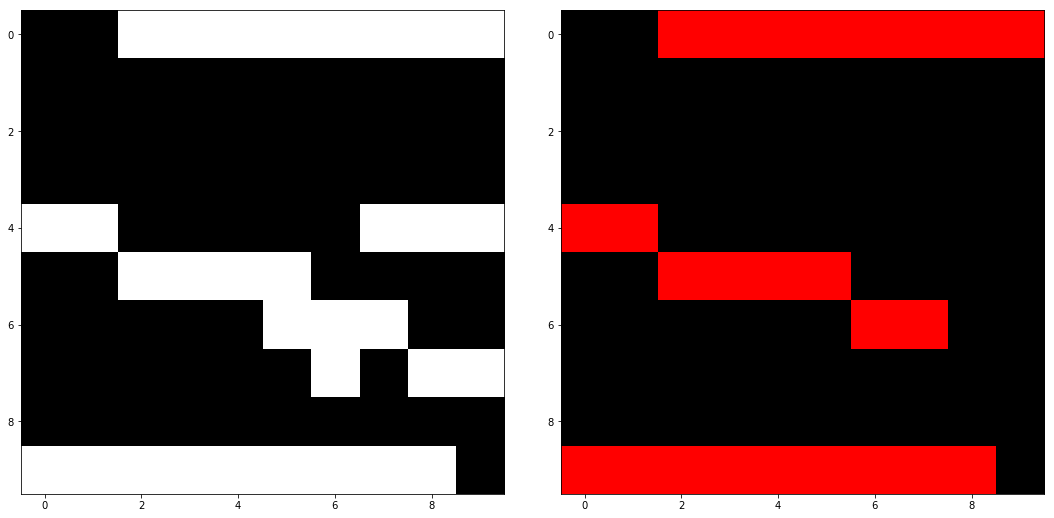

Lines found by Hough transform: 
 [[[0 4 7 6]]

 [[2 0 9 0]]

 [[0 9 8 9]]]


In [18]:
img = images_canny[0][310:320, 10:20]

lines = hough_lines(img, rho=1, theta=np.pi/180, threshold=7, min_line_len=5, max_line_gap=5)
img2 = draw_lines(img, lines, color=[255, 0, 0], thickness=1)

display_images([img, img2], figsize = (15, 7))

print("Lines found by Hough transform: \n", lines)

The next chunk of code implements the filtering algorithm based on edge orientation.

In [19]:
def angle(v1, v2):
    "Return angle between vectors v1 and v2 in degrees."
    return np.arccos(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi

def sum_max_magn(v1, v2):
    "Return sum or diff of vectors v1 and v2 such that the magnitude of the result vector is maximized."
    a = v1 + v2
    b = v1 - v2
    return a if np.linalg.norm(a) >= np.linalg.norm(b) else b

def line_vectors(image, thrAngle, rho, theta, threshold, min_line_len, max_line_gap):
    """Return two vectors: One representing the sum of all lines with an angle in range [thrAngle:180-thrAngle] with 
    respect to the y-axis and a second one for all lines in range [0:thrAngle] || [180-thrAngle:180]. 
    
    Return None for nl and/or ll if no line in the expected angular range was found.
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    thrAngle     -- threshold angle (see return values)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    nl           -- sum of all lines with an angle in range [0:thrAngle] || [180-thrAngle:180]
    ll           -- sum of all lines with an angle in range [thrAngle:180-thrAngle]
    """
    assert image.shape != (0, 0)
    lines = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)  
    nl = np.array([0, 0])
    ll = np.array([0, 0])
    if lines is None: # hough returns None if no lines were found (i.e. don't change original figure)
        return None, None
    ey = np.array([0, 1])
    for line in lines:
        x1, y1, x2, y2 = line[0] 
        # vector in direction of line
        el = np.array([y1, x1]) - np.array([y2, x2]) # numpy and opencv interchange rows and columns
        if (angle(el, ey) <= thrAngle) or (angle(el, ey) >= 180-thrAngle):
            nl = sum_max_magn(nl, el) 
        else:
            ll = sum_max_magn(ll, el) 
    if np.array_equal(nl, np.array([0, 0])):
        nl = None
    if np.array_equal(ll, np.array([0, 0])):
        ll = None    
    return nl, ll


def setup_grid(image, size, thrAngle, rho, theta, threshold, min_line_len, max_line_gap):
    """Return grid of subimages with boolean values indicating if subimage contains potential lane line.

    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    size         -- size of sub-images
    thrAngle     -- threshold angle (see return values)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    grid         -- Dictonary with keys indicating subimages and boolean values indicating if subimage contains lane line.
                    {(x1, x2, y1, y2) : True, (x1, x2, y1, y2): False, ...}
    """
    subs = subimage(image, size)
    grid = {}
    for sub in subs:
        x1, x2, y1, y2  = sub
        nl, ll = line_vectors(image[x1:x2, y1:y2], thrAngle, rho, theta, threshold, min_line_len, max_line_gap)
        if ll is None:
            grid[(x1, x2, y1, y2)] = False
        elif nl is None:
            grid[(x1, x2, y1, y2)] = True             
        elif np.linalg.norm(ll) >= np.linalg.norm(nl):
            grid[(x1, x2, y1, y2)] = True            
        elif np.linalg.norm(ll) < np.linalg.norm(nl):
            grid[(x1, x2, y1, y2)] = False 
    return grid    

def heatmap(image, grid):
    """Return image where subimages with lane=True are highlighted in white (useful to visualize result of setup_grid)."""
    img = np.zeros_like(image)
    for coo, lane in grid.items():
        x1, x2, y1, y2 = coo
        if lane:
            img[x1:x2, y1:y2] = 255 
    return img

def filter_edge_orientation(image, grid):
    """Zeros all sub-images of image (as specified by grid) with lane=False
    
    Args:
    image        -- binary image (e.g. output of the Canny function of opencv)
    grid         -- output of setup_grid
    """
    for coo, lane in grid.items():
        x1, x2, y1, y2 = coo
        if lane == False:
            image[x1:x2, y1:y2] = 0

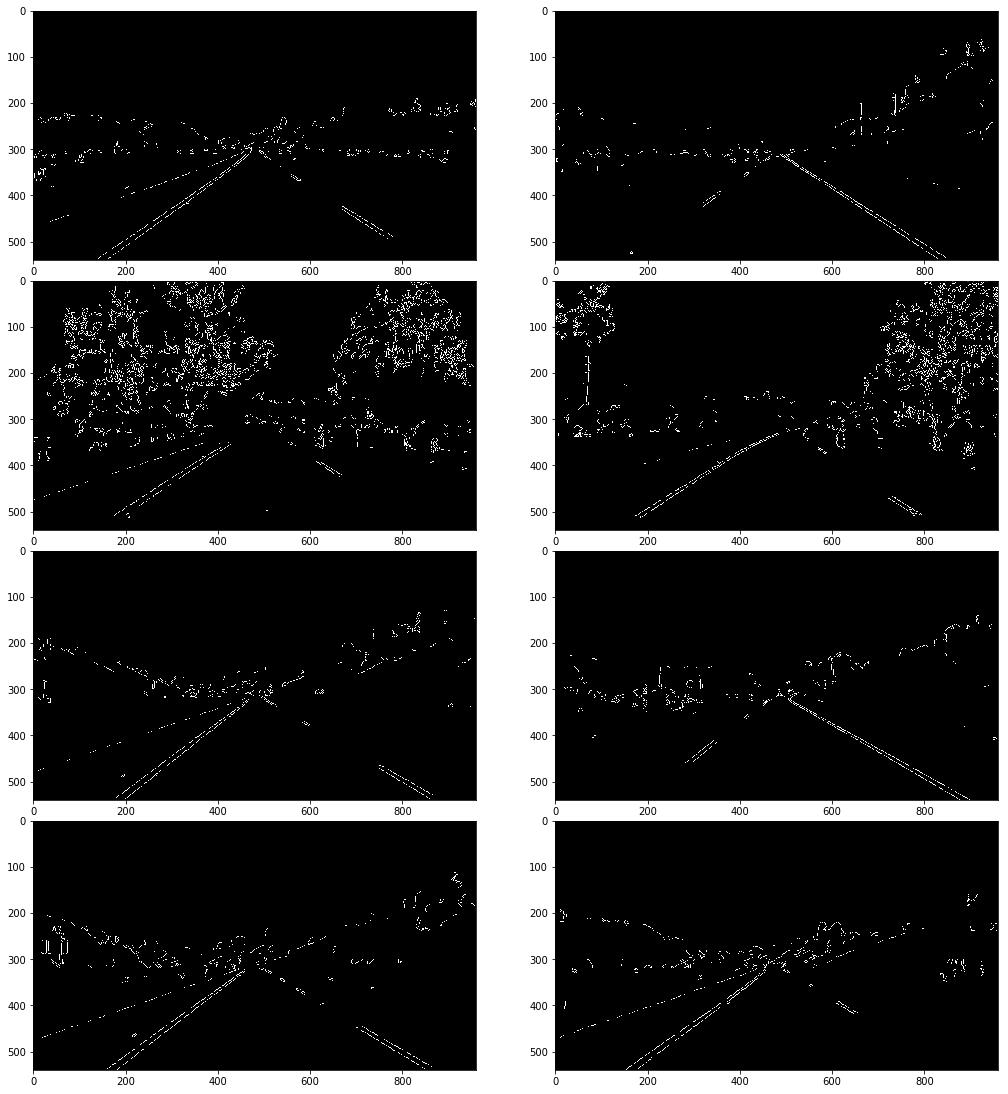

In [21]:
images_filter_eo = np.copy(images_canny)

grids = [setup_grid(image, size = 10, thrAngle = 15, rho = 1, theta = np.pi/180, threshold = 7, 
                    min_line_len = 5, max_line_gap = 5) 
        for image in images_canny]
[filter_edge_orientation(image, grid) for image, grid in zip(images_filter_eo, grids)] 
heatmaps = [heatmap(image, grid) for image, grid in zip(images_canny, grids)]

display_images(images_filter_eo, figsize = (15, 15))


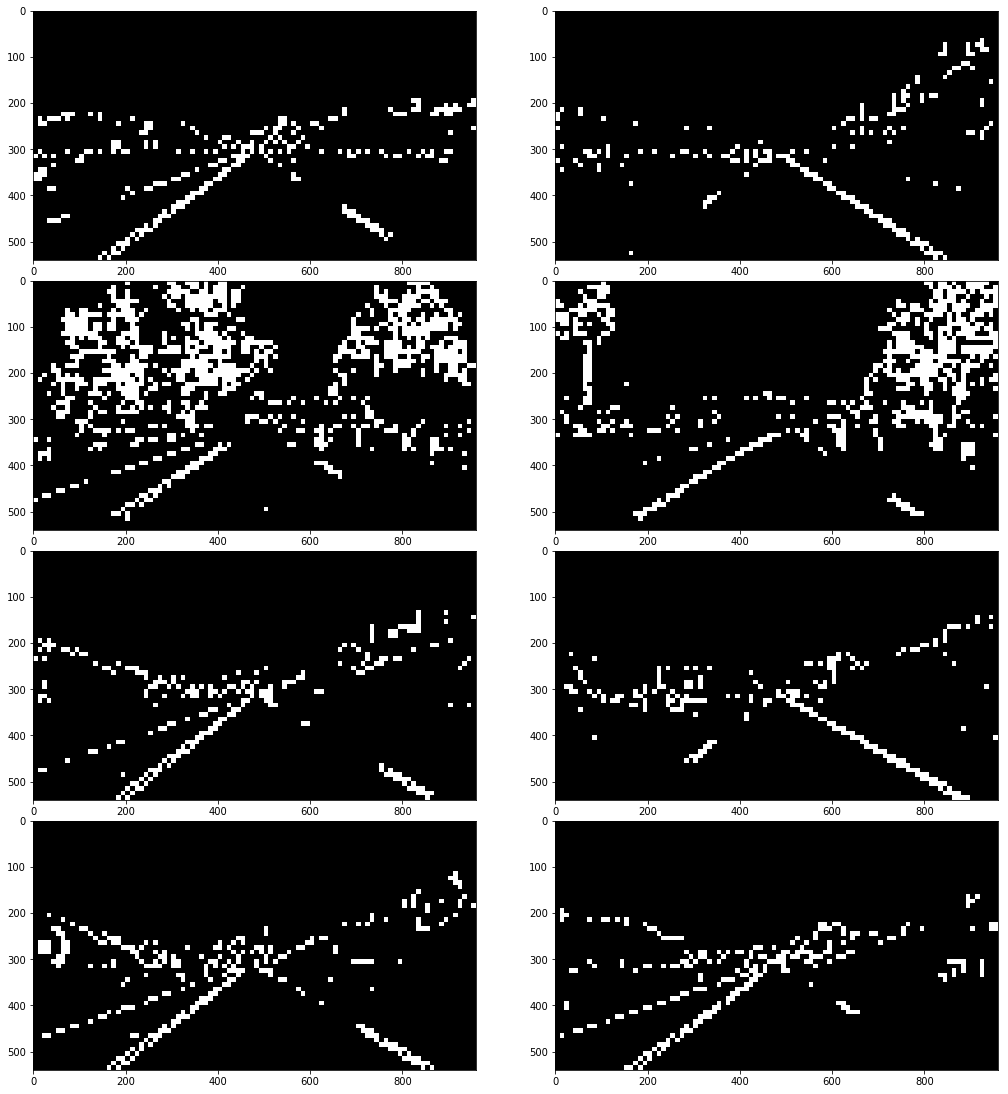

In [24]:
display_images(heatmaps, figsize = (15, 15))

The filtering algorithm based on edge orientation works well. A good portion of noisy edges were filtered out. However, sometimes a subimage is zeroed although it contained a piece of the actual lane line marking. In order to fix this issue we apply a mask which looks at the neighbouring subimage. If any of the top-left, top-right or top subimages contains a piece of the lane line marking the current subimage is not zeroed.

In [26]:
def reconstruct_lane(grid, size):
    """Reconstruct grid: If neighbouring top left, top right or top subimages contains line lane
    assume subimage contains line lane as well."""
    agrid = grid.copy() # copy dict
    for coo, lane in grid.items():
        for neigh in neighbours(coo, size):
            if neigh in grid.keys() and grid[neigh]==True:
                agrid[coo] = True
    return agrid        
        
def neighbours(coo, size):
    "Return coordinates of the neighbouring subimages on the top left, top right and top of the current subimage."
    x1, x2, y1, y2 = coo
    top = (x1 + size, x2 + size, y1, y2)
    topleft = (x1 + size, x2 + size, y1 - size, y2 - size)   
    topright = (x1 + size, x2 + size, y1 + size, y2 + size)
    return (topleft, top, topright)

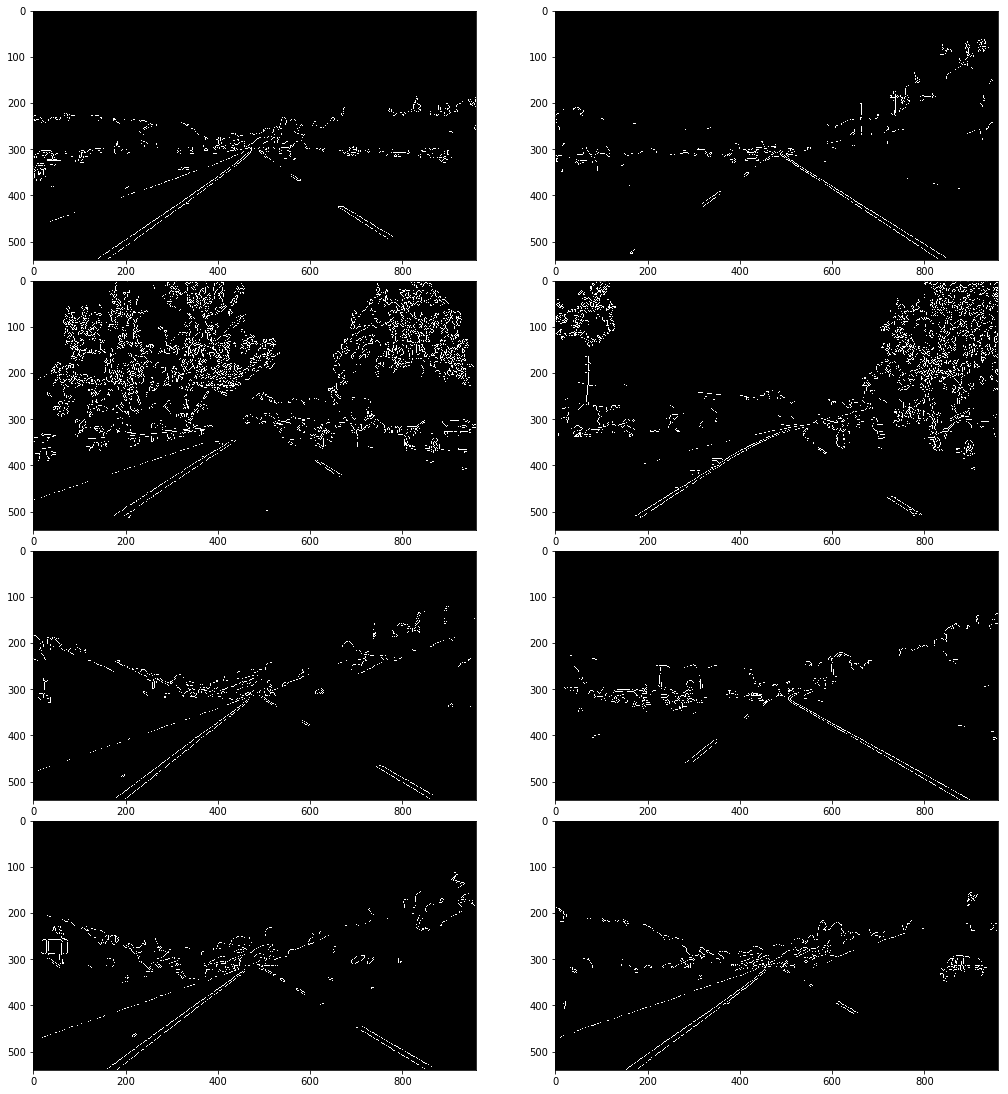

In [28]:
images_filter_eo = np.copy(images_canny)

grids = [reconstruct_lane(setup_grid(image, size = 10, thrAngle = 15, rho = 1, theta = np.pi/180, 
                                     threshold = 7, min_line_len = 5, max_line_gap = 5), size = 10) 
        for image in images_canny]
[filter_edge_orientation(image, grid) for image, grid in zip(images_filter_eo, grids)] 
heatmaps = [heatmap(image, grid) for image, grid in zip(images_canny, grids)]


display_images(images_filter_eo, figsize = (15, 15))

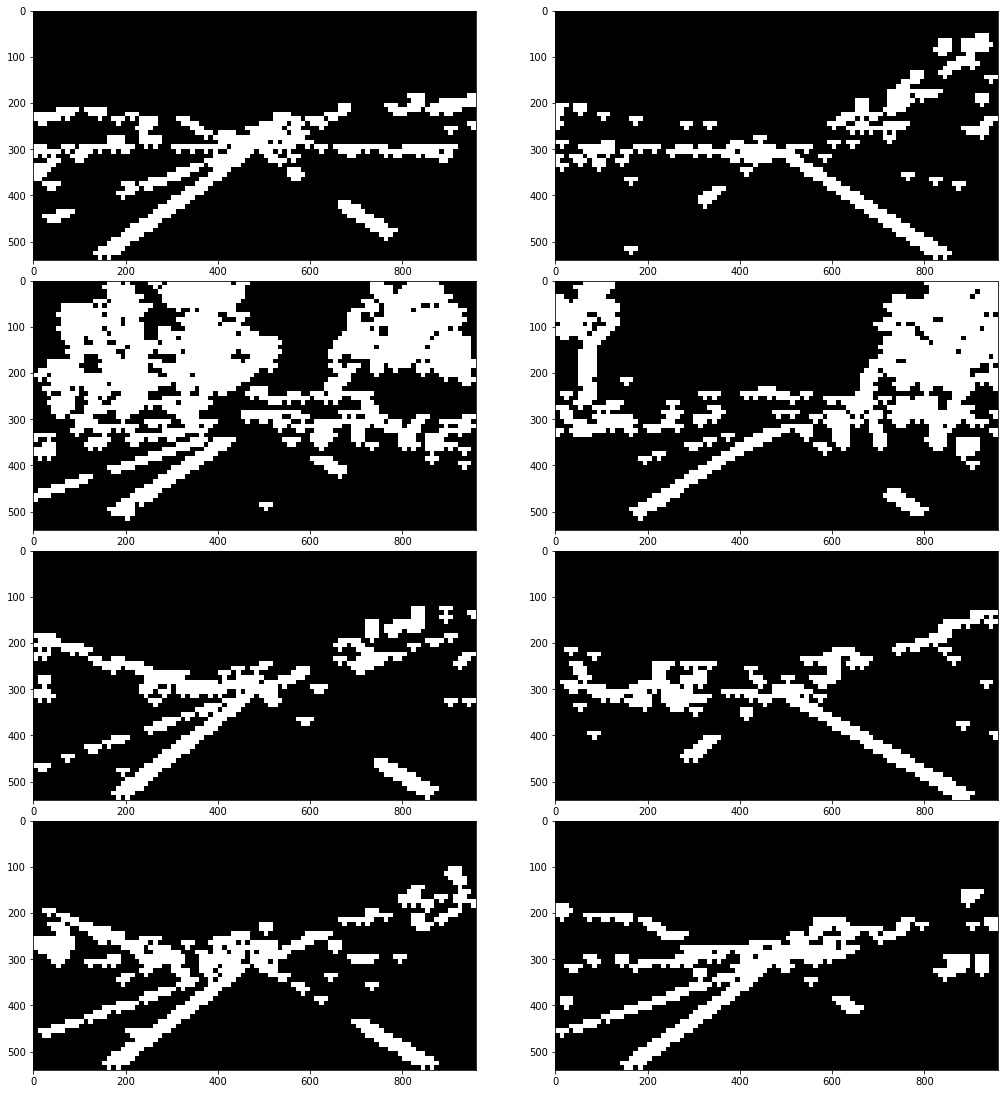

In [29]:
display_images(heatmaps, figsize = (15, 15))

On the expense of some additional noisy edges the lane lines were reconstructed.

## 5. Edge filtering based on gradients

Although the previous algorithm filtered out many noisy edges there are still some present. We exploit two additional features of lane line markings to distinguish them from noisy edges.

The first one makes use of the fact that lane line markings consist of two parallel lines after application of the Cany edge detector. Typical lane line markings have a maximum width of 30 pixels in y-direction. We therefore assume that any non-zero pixel which does not have a neighbouring non-zero pixel in y-direction with a maximum distance of 30 pixels is a "noisy edge". 

![gradient](images/gradient.png)
__Fig. 2__ _Direction of the gradients of lane line markings. For the left lane line the angles of the two gradient vectors with respect to the x-axis fall in the range $0^{\circ}-90^{\circ}$ and $180^{\circ}-270^{\circ}$ respectively. In contrast the angles of the gradients of the right lane line fall in the range $90^{\circ}-180^{\circ}$ and $270^{\circ}-360^{\circ}$._

The filter can be refined further when we consider the direction of the gradients at the two edges of the lane line. The directions of the gradients are illustrated in Fig. 2. For the left lane one gradient vector has an angle in the range $0^{\circ}-90^{\circ}$ with respect to y-axis. The second gradient has an angle in the range $180^{\circ}-270^{\circ}$. Similar statements can be made for the right lane line. Note that a gradient vector always point into the direction of maximum change in intensity i.e. they are perpendicular to edges.

We look for pairs of pixels which are no more than 30 pixels apart and where its corresponding gradient angle is in the range $0^{\circ}-90^{\circ}$ ($90^{\circ}-180^{\circ}$) while the other one is in the range $180^{\circ}-270^{\circ}$ ($270^{\circ}-360^{\circ}$). Any pixel which does not fullfill this condition is zeroed. 



In [30]:
def phase(image):
    """Return angle of gradient vector at location of each pixel. Expects a gray-scale image.
    Angles are assigned to four quadrantes represented by integers between 1 and 4. 
    1: 270 <= angle <= 360
    2: 180 <= angle <  270
    3: 90  <= angle <  180
    4: 0   <= angle <   90
    """
    gradientX = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    gradientY = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    angle = cv2.phase(gradientX, gradientY, angleInDegrees=True) 
    angle[(0 <= angle[:, :]) & (angle[:, :] < 90)]    = 4 
    angle[(90 <= angle[:, :]) & (angle[:, :] < 180)]  = 3
    angle[(180 <= angle[:, :]) & (angle[:, :] < 270)] = 2
    angle[(270 <= angle[:, :]) & (angle[:, :] <= 360)] = 1
    return angle    
    
def filter_pos_y(iq, fq, size, angle):
    """Check if pixel with angle quadrant 'fq' is within 'size' pixels of pixel with angle quadrant 'iq'. 
    Otherwise zero pixel 'iq'.
    
    Search is done in increasing y-direction.    
    
    Args:
    iq    -- angle quadrant of starting pixel
    fq    -- angle quadrant we are looking for
    size  -- size of windows in which we look for fq
    angle -- numpy array of angle values
    """
    _, ymax = angle.shape
    for pix in np.argwhere(angle == iq):
        flag = False
        for y in np.arange(pix[1], pix[1] + size, 1) :
            if y < ymax and angle[pix[0], y] == fq:
                flag = True
        if flag == False:
            angle[pix[0], pix[1]] = 0

def filter_neg_y(iq, fq, size, angle):
    """Check if pixel with angle quadrant 'fq' is within 'size' pixels of pixel with angle quadrant 'iq'. 
    Otherwise zero pixel 'iq'.
    
    Search is done in decreasing y-direction.    
    
    Args:
    iq    -- angle quadrant of starting pixel
    fq    -- angle quadrant we are looking for
    size  -- size of windows in which we look for fq
    angle -- numpy array of angle values
    """
    for pix in np.argwhere(angle == iq):
        flag = False
        for y in np.arange(pix[1], pix[1] - size, -1):
            if y >= 0 and angle[pix[0], y] == fq:
                flag = True
        if flag == False:
            angle[pix[0], pix[1]] = 0

def filter_gradient(imageg, image, width):
    """Filter out noisy edges of image based on assumptions of lane line markig width and direction of gradients.
    
    Args:
    imageg       -- grayscale image
    image        -- binary image (e.g. output of the Canny function of opencv)
    width        -- maximum width of lane line         
    """
    angle = phase(imageg)
    mask = (image[:, :] == 255)
    angle[~mask] = 0
    filter_pos_y(1, 3, width, angle)  
    filter_pos_y(4, 2, width, angle)  
    filter_neg_y(3, 1, width, angle)  
    filter_neg_y(2, 4, width, angle) 
    #angle[angle != 0] = 255
    return angle.astype('uint8')
    

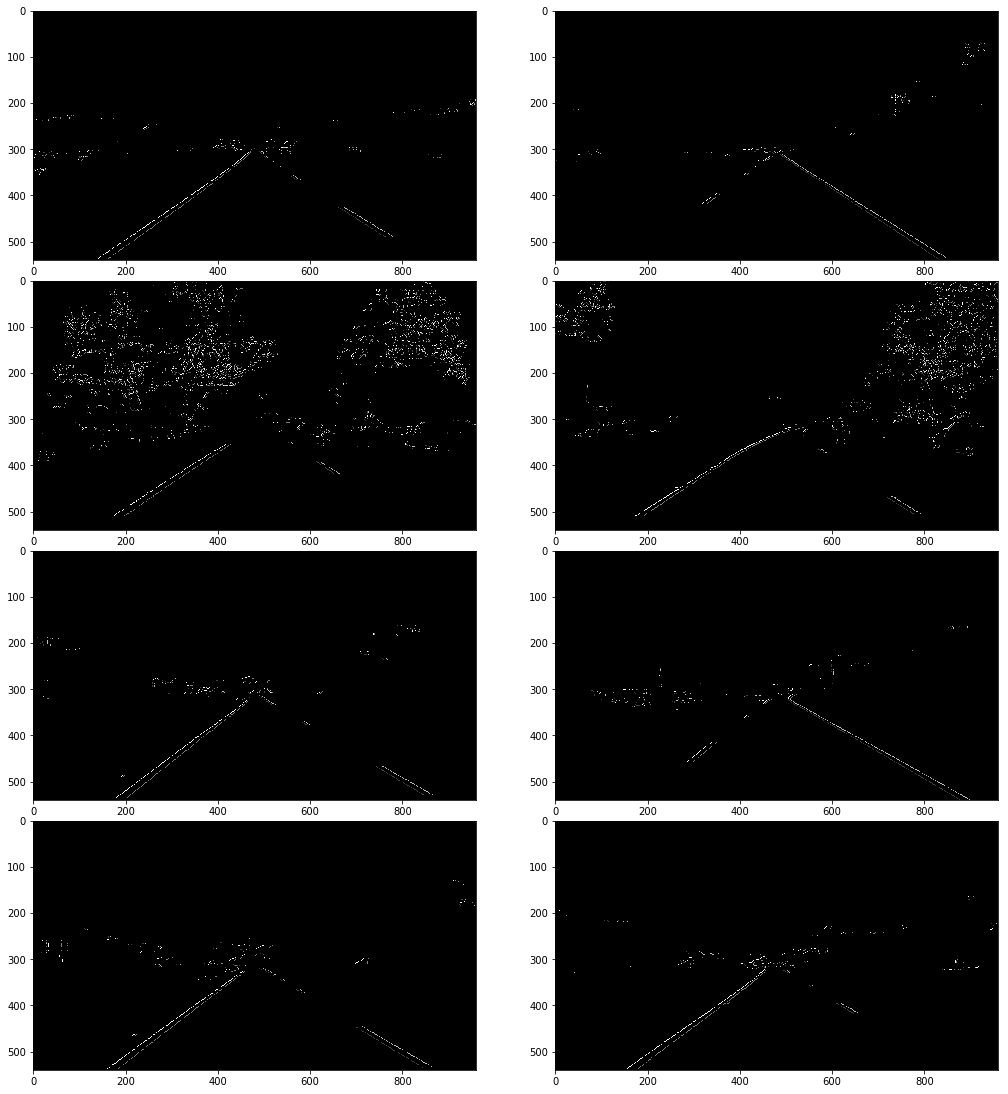

In [31]:
images_filter_g = [filter_gradient(p1, p2, 30)  for p1, p2 in zip(images_gray, images_filter_eo)]         
    
display_images(images_filter_g, figsize = (15, 15))

## 6. Region selection

The region selection seems to be straight forward because all lane lines appear in the same general region of the pictures. The choice of the region has to take into account that a part of the car is visible at the bottom of some pictures. A polygon with four sides is a reasonable choice. It is important to define this polygon relative the size of the image (and not in absolute values) since images can have different resolutions and sizes.

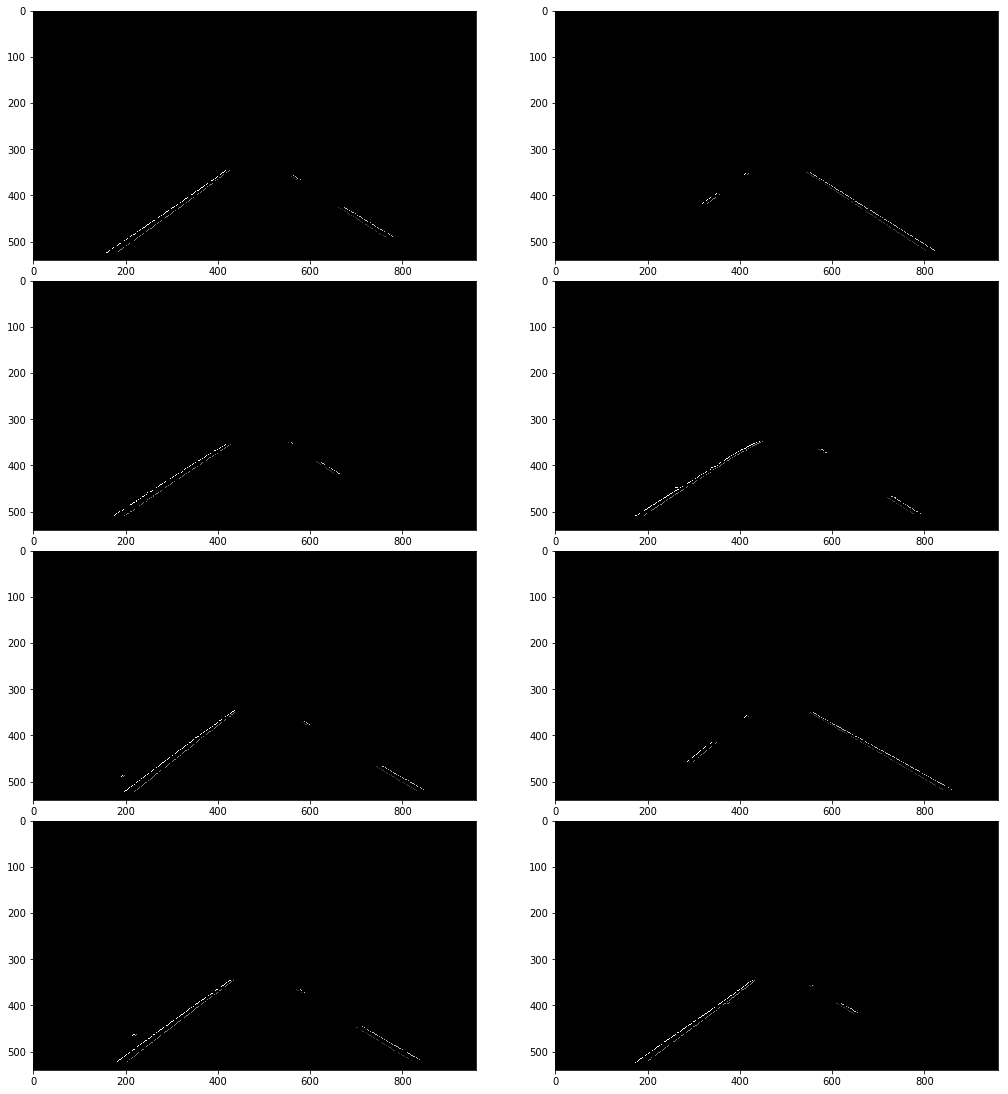

In [33]:
def region_of_interest(img):
    """Zero all pixels expect pixels in region defined by vertices."""
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        ignore_mask_color = (255,) * img.shape[2] 
    else:
        ignore_mask_color = 255
        
    bottom_left = (0.10, 0.97)
    top_left = (0.41, 0.64)
    top_right = (0.59, 0.65)
    bottom_right = (0.96, 0.96)
    xdim, ydim  = img.shape
    bl_y, bl_x = bottom_left
    tl_y, tl_x = top_left
    tr_y, tr_x = top_right
    br_y, br_x = bottom_right
    v1 = int(bl_y*ydim), int(bl_x*xdim)
    v2 = int(tl_y*ydim), int(tl_x*xdim)
    v3 = int(tr_y*ydim), int(tr_x*xdim)
    v4 = int(br_y*ydim), int(br_x*xdim)
    vertices = np.array([[v1, v2, v3, v4]])   
        
    # set pixel intensities to ignore_mask_color inside region defined by vertices
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # zero all pixel outside of region defined by vertices
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



images_reg = [region_of_interest(image) for image in images_filter_g]

display_images(images_reg, figsize = (15, 15))


## 6. Otsu's method

The last filter is based on Otsu's method. Otsu's method works best for bimodal images i.e. the distribution of intensity values of the grayscale image forms two peaks. Otsu's method chooses automatically a threshold which separates both peaks best and converts the image in a binary image (all values of the first class are zeroed and all values of the second class are set to an intensity value of 255). The problem at hand seems to fit to the requierment of a bimodal distribution since lane line markings are painted in high contrast color to the dark surface of the road. 

However, we apply Otsu's method to the full image (this can be improved taking a similar approach as for edge orientation with small subimages). Therefore it is likely that other features of the image dominate the intensity distribution (e.g. bright sunlight instead of lane line markings). In this case Otsu's method does not help much to filter noisy edges (but it doesn't hurt either). However, if the condition of a bimodal distribution is fulfilled than Otsu's method can constitute an excellent filter.   

The following to images how a case where Otsu's method works well (provided the lane line marking right away and filter any noisy edges in the region of interest) and one where it fails.

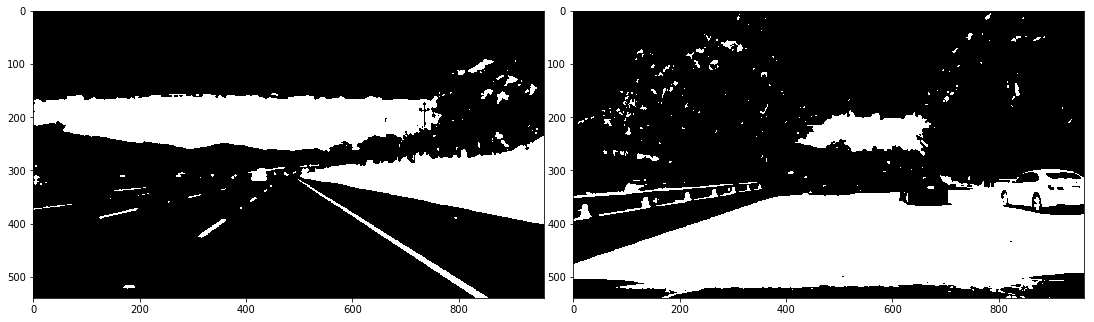

In [39]:
def otsu_filter(img, gimg):
    """Apply Otsu's method as a filter. Any pixel assigned to the lower class is zeroed.
    
    Args:
    img  -- apply Otsu's method as filter to this image (typically the output of region selection)
    gimg -- grayscale image
    """
    imgc = np.copy(img)
    th3 = otsu_method(gimg)
    mask = (th3 == 0)
    imgc[mask] = 0                          
    return imgc 

def otsu_method(img):
    """Apply Otsu's method to image."""
    blur = cv2.GaussianBlur(img, (5,5), 0)
    ret3, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)                          
    return th3  
                              

images_otsu_illustration = [otsu_method(p1)  for p1 in images_gray[1:3]]         
    
display_images(images_otsu_illustration, figsize = (15, 15))

Otsu's method was applied to all images and is part of the pipeline.

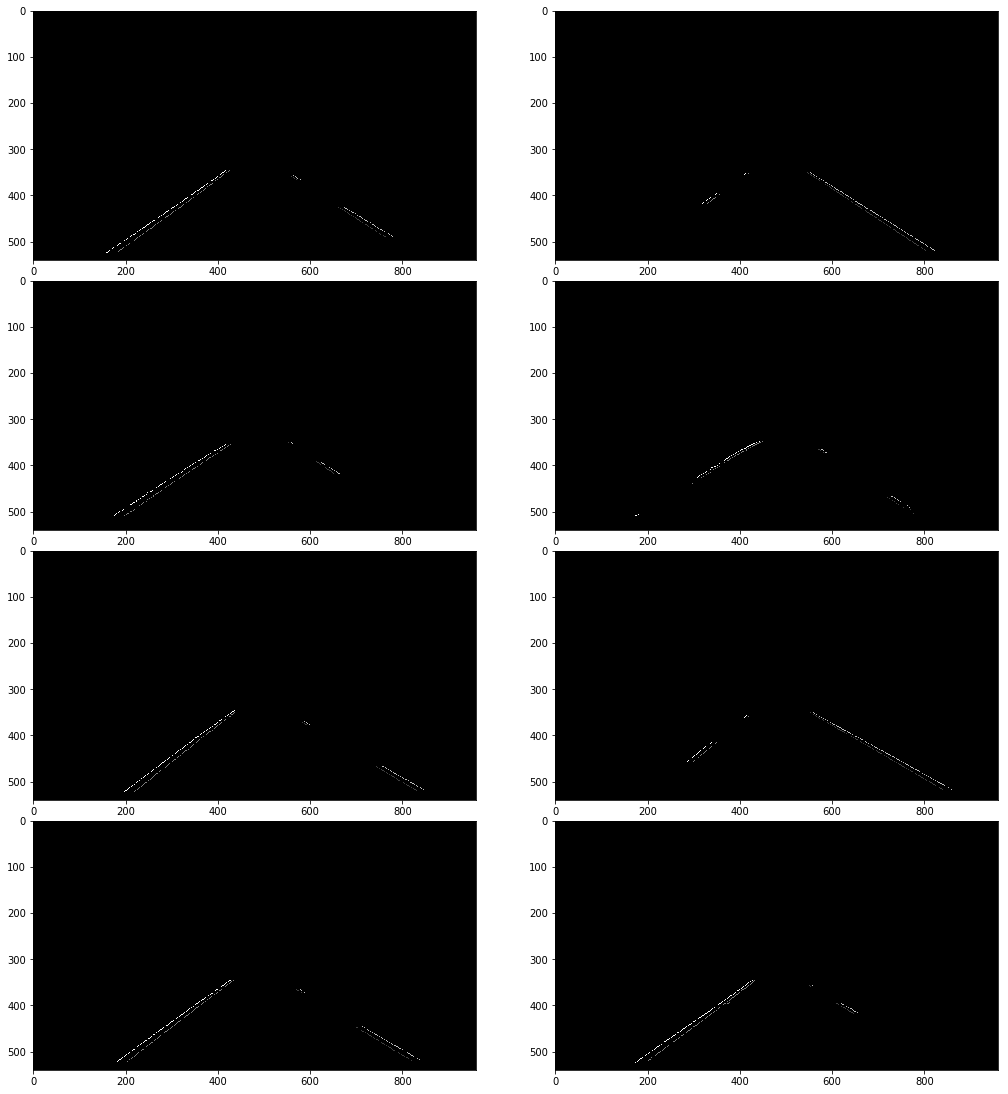

In [42]:
images_otsu = [otsu_filter(p1, p2) for p1, p2 in zip(images_reg, images_gray)]

display_images(images_otsu, figsize = (15, 15))

## 7. Hough transform: Finding lane lines

Our pipeline was able to filter most of the noisy edges while retaining the actual lane lines. In case of the eight sample images basically all noisy edges were removed and only the lane line marking are left. As a last step we fit the lane line markings with a Hough transform. We fit left and right lane line markings (based on the direction of the gradient) separately. Typically the Hough transform will find several lines for the left as well as the right lane line. Therefore we average over these line to determine averages line which are used for highlighting the lane lines in the original images.

In [50]:
def average_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    """Fit right and left lane line markings using Hough transform and average fitted lines.

    Args:
    image        -- output of filter pipeline. Pixels are labeled according to their gradient (1, 2, 3, 4)
    rho          -- distance resolution in pixels 
    theta        -- angle resolution in radians
    threshold    -- threshold + 1 is the minimum number of votes a line needs to be returned
    min_line_len -- minimum length of line to be returned
    max_line_gap -- maximum distance of two line segments to be considered as a single line    
    Return values:
    avg          -- Dictonary containing average left and right lane line marking
                    {'left': (slope, intercept), 'right': (slope, intercept)}
    """
    
    avg = {}
    for classes in ((1, 3), (2, 4)):
        c1, c2 = classes
        img = np.copy(image) 
        # fit right and left lane line separately
        mask = (img[:, :] == c1) | (img[:, :] == c2)
        img[~mask] = 0
        lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap) 
        if lines is None:
            continue
        
        # determine slope, intercept and length of all lines found by Hough transform
        slope = []
        intercept = []
        length = []
        for line in lines:
            y1, x1, y2, x2 = line[0]  # interchanged x, y coordiantes
            if x1 == x2: continue
            slope.append((y1 - y2)/(x1 - x2))
            intercept.append(y1 - slope[-1]*x1 - slope[-1])
            length.append((x1-x2)**2 + (y1-y2)**2)
            
        # use length of lines as weights for averaging
        if slope and intercept and length:
            avgSlope = np.dot(slope, length) / sum(length)  
            avgIntercept = np.dot(intercept, length) / sum(length)      
            if classes == (1, 3):
                avg['right'] = (avgSlope, avgIntercept)
            else:
                avg['left'] = (avgSlope, avgIntercept)                
    return avg
    
def pixel_points(image, avg, upper=1):
    """Convert average slope and intercept to pixel values for cv2.line.
    
    Args:
    image -- image where lane lines are to be drawn on
    avg   -- {'left': (slope, intercept), 'right': (slope, intercept)}
    upper -- scaling factor determining the lengt of the drawn line
    """
    assert 0 < upper <= 1
    if len(image.shape)==2:
        xmax, ymax = image.shape
    else:
        xmax, ymax, _ = image.shape
    xmin = int(upper*xmax)
    points = {'left' : None, 'right' : None}
    for lane, line in avg.items():
        slope, intercept = line
        y1 = int(slope*xmax + intercept)
        y2 = int(slope*xmin + intercept)
        if lane == 'right':
            points['right'] = (y1, xmax, y2, xmin)
            #points['right'] = np.array([[[y1, xmax, y2, xmin]]])
        else:
            points['left'] = (y1, xmax, y2, xmin)
            #points['left'] = np.array([[[y1, xmax, y2, xmin]]])
    return points

def draw_lane_line(image, line, color=[255, 0, 0], thickness=20):
    """Draw single line on image.
    
    Args:
    image     -- image where lane lines are to be drawn on (typically the original image)
    line      -- start and end point of line (x1, y1, x2, y2) 
    color     -- color of line
    thickness -- line thickness
    """
    imgl = np.zeros_like(image)
    if line is not None:
        x1, y1, x2, y2 = line
        cv2.line(imgl, (x1, y1), (x2, y2),  color, thickness)
    return cv2.addWeighted(image, 1.0, imgl, 0.95, 0.0)
    

It is useful to write a dedicated class to find lane lines. The function process_image implements the entire pipeline. It further averages the lane lines found in the previous nine images (in a video stream) and the lines of the current image. This average line is the one drawn on the current image. It was also necessary to implement an outlier detection. If the start or end points of the line of the current image deviates strongly from the average line of the previous ten images it is discarded. Instead the average line of the previous ten images is drawn on the current image.

In [49]:
import collections

class FindLaneLines:
    def __init__(self):
        # container to save previously determined lane lines
        self.memory = 10
        self.left = collections.deque(maxlen=self.memory)
        self.right = collections.deque(maxlen=self.memory)
        # current average
        self.left_avg = (0, 0, 0, 0)
        self.right_avg = (0, 0, 0, 0)
        # configuration
        self.config = {
           # region
           'bottom_left' : (0.10, 0.97),
           'top_left' : (0.41, 0.64),     
           'top_right' : (0.59, 0.65),  
           'bottom_right' : (0.96, 0.96),
           # canny
           'low' : 50,
           'high' : 150,
           'kernel': 5,
           # filter noisy edges
           'size' : 10,
           'angle' : 15,
           'rho1' : 1,
           'theta1' : np.pi/180,
           'thresh1' : 7,
           'min_line_len1' : 5,
           'max_line_gap1' : 5,
           'width' : 30,
           # hough lines
           'rho2' : 1,
           'theta2' : np.pi/180,
           'thresh2' : 20,
           'min_line_len2' : 20,
           'max_line_gap2' : 300        
         }
                
        
    def process_image(self, image):
        """Process image with pipeline and return image with detected lane lines drawn on it."""
        
        # convert image to grayscale and search edges
        img_gray = grayscale2(image)
        blur_gray = cv2.GaussianBlur(img_gray, (self.config['kernel'], self.config['kernel']), 0)
        img_canny = canny(blur_gray, self.config['low'], self.config['high'])
       
        # filter noisy edges
        # edge orientation
        grid = setup_grid(img_canny, 
                      size = self.config['size'], 
                      thrAngle = self.config['angle'], 
                      rho = self.config['rho1'], 
                      theta = self.config['theta1'], 
                      threshold = self.config['thresh1'], 
                      min_line_len = self.config['min_line_len1'], 
                      max_line_gap = self.config['max_line_gap1'])
        grid_re = reconstruct_lane(grid, self.config['size'])
        filter_edge_orientation(img_canny, grid_re)  
        # gradient
        images_filter_g = filter_gradient(img_gray, img_canny, self.config['width'])      
        # select region
        images_reg = region_of_interest(images_filter_g) 
        # apply otsu filter
        images_otsu = otsu_filter(images_reg, img_gray)
       
        # find lane lines
        avg = average_lines(images_otsu, 
                            rho = self.config['rho2'], 
                            theta = self.config['theta2'], 
                            threshold = self.config['thresh2'], 
                            min_line_len = self.config['min_line_len2'],
                            max_line_gap = self.config['max_line_gap2'])        
        points =  pixel_points(image, avg, 0.62)  
        
            
        def aver_line(lines, line, avg, perc):
            """Compute average of current and last self.memory-1 lane lines.
            
            Current lane line is not considered if it is an outlier.
            """
            if line is not None:
                if (len(lines) < self.memory) or (outlier(avg, line, perc)):
                    lines.append(line) 
                
            if len(lines)>0:
                sumx1 = sumy1 = sumx2 = sumy2 = 0
                for line  in lines:
                    y1, x1, y2, x2 = line
                    sumy1 += y1
                    sumx1 += x1
                    sumy2 += y2
                    sumx2 += x2              
                line = (sumy1/len(lines), sumx1/len(lines), sumy2/len(lines), sumx2/len(lines))
                line = tuple(int(l) for l in line)
            return line
        
        def outlier(avg, line, perc):
            """Check if current line is an outlier with respect to the average of the last self.memory lane lines.
            
            Args:
            avg   -- start and and point (y1, x1, y2, x2) of the current average
            line  -- start and and point (y1, x1, y2, x2) of the current line
            perc  -- deviation in order to flag a line as outliers
            Return value:
            Return true if current line is no outlier.
            """
            cond1 = line[0]*(1-perc) <= avg[0] <= line[0]*(1+perc) 
            cond2 = line[1]*(1-perc) <= avg[1] <= line[1]*(1+perc) 
            cond3 = line[2]*(1-perc) <= avg[2] <= line[2]*(1+perc) 
            cond4 = line[3]*(1-perc) <= avg[3] <= line[3]*(1+perc) 
            return cond1 and cond2 and cond3 and cond4
              
        # determine average lane line marking    
        self.left_avg = aver_line(self.left, points['left'], self.left_avg, 0.25)
        self.right_avg = aver_line(self.right, points['right'], self.right_avg, 0.25)
            
        #draw lane line marking    
        image = draw_lane_line(image, self.left_avg, color=[255, 0, 0], thickness=10)
        image = draw_lane_line(image, self.right_avg, color=[255, 0, 0], thickness=10)
        return image


### Test of the full pipeline on images

We test our FindLaneLines class and its process_image function on the eight sample images. All lane line markings were detected correctly in these images. Even the lane line markings of the two images from  the 'challenge' are detected despite bright sun light and shadows.

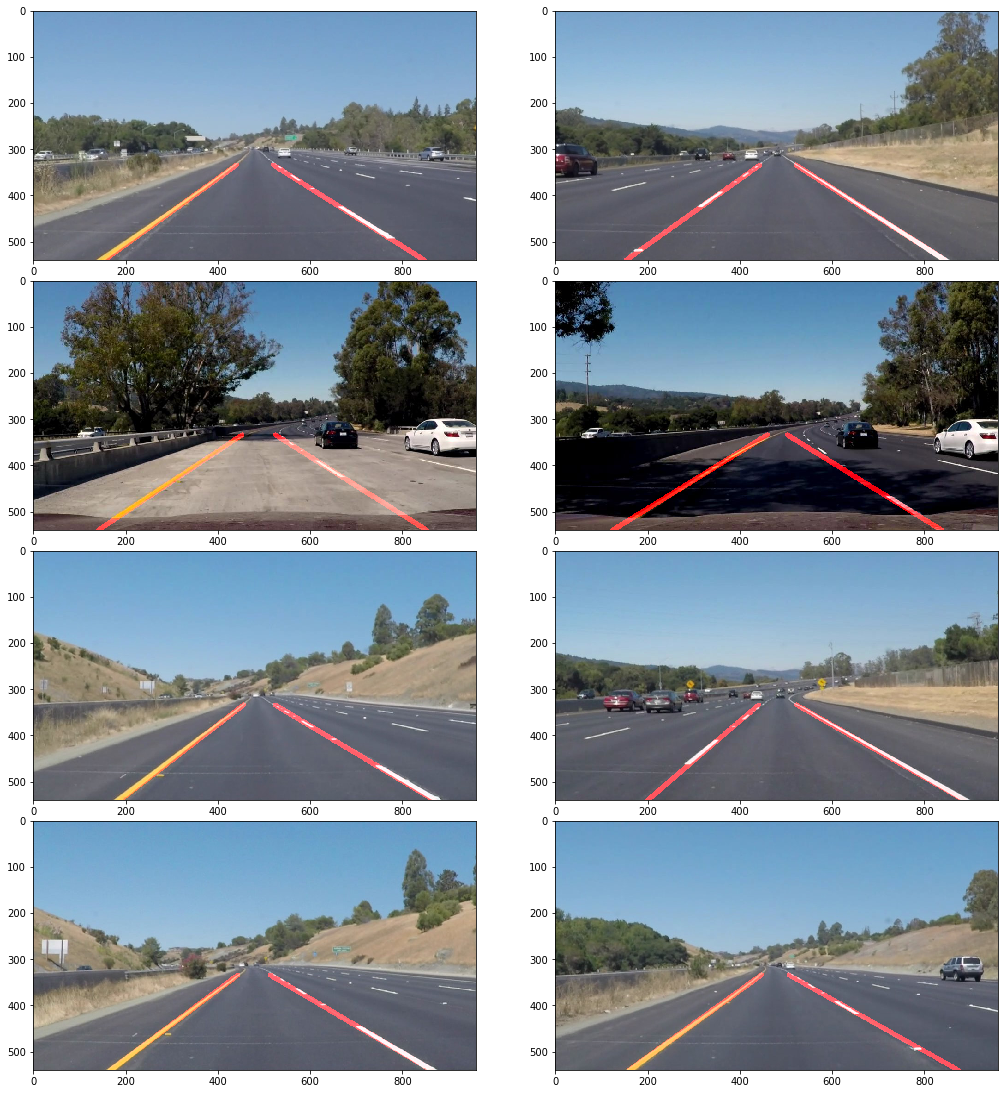

In [48]:
pic = []
for img in images:
    detector = FindLaneLines()
    pic.append(detector.process_image(img))
    
display_images(pic, figsize = (15, 15))

### Test of the full pipeline on videos

A more challenging test of the algorithm constitutes a video stream (basically a series of images). Udacity provides three video streams to test the algorithm:
* solidWhiteRight.mp4: Dashed white lane line on the left and solid white line on the right
* solidYellowLeft.mp4: Solid yellow line on the left and dashed white line on the right
* challenge.mp4:  Solid yellow line on the left and dashed white line on the right

The video challenge.mp4 is by far the most challenging one due to bright sunlight and shadows. Nevertheless our algorithm was able to detect in all three videos the lane line markings correctly. 

In [55]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os


def process_video(video_input, video_output):
    detector = FindLaneLines()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process_image)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)

In [ ]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight.mp4') 

%time process_video('solidYellowLeft.mp4', 'solidYellowLeft.mp4') 

%time process_video('challenge.mp4', 'challenge.mp4') 

* [White lane line](https://www.youtube.com/watch?v=visIHRMtAzc)
* [Yellow lane line](https://www.youtube.com/watch?v=T3CUTCC07bc)
* [Challenge](https://www.youtube.com/watch?v=wYCKcxyzt90)

## 8. Conclusion

We developed a algorithm which is able to detect lane line markings in images and video stream. The algorithm is robust and gets only slightly confused by bright sunlight and shadows. Nevertheless there is room for improvement:

* try to fit a curved line instead of a straight line (extensions of the Hough transform are capable of doing this)
* apply filter based on Otsu's method to subimages and not on full image
* optimize all parameters
* algorithm is not efficient and not capable of handling real-time requierments.